In [2]:
import gc
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc
import cv2
import torch
from torchvision import transforms
from torchvision.transforms.functional import to_pil_image
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

gc.collect()
torch.cuda.empty_cache()
matplotlib.rcParams.update({'font.size': 14})
plt.rcParams['axes.unicode_minus'] = False

In [3]:
tissue_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
PATCH_SIZE = (512, 512) # width, height

def is_inside_tissue(_mask):
    tissue_area = np.sum(_mask) // 255
    mask_area = np.prod(PATCH_SIZE)
    return (tissue_area / mask_area) > TISSUE_AREA_RATIO

def get_otsu_mask(_img):
    v = cv2.cvtColor(_img, cv2.COLOR_RGB2GRAY)
    v = cv2.medianBlur(v, 15)
    _, timg_th = cv2.threshold(v, -1, 255, cv2.THRESH_OTSU)
    timg_th = cv2.morphologyEx(timg_th, cv2.MORPH_OPEN, tissue_kernel, iterations=2)
    timg_th = cv2.morphologyEx(timg_th, cv2.MORPH_CLOSE, tissue_kernel, iterations=2)
    timg_th = cv2.morphologyEx(timg_th, cv2.MORPH_OPEN, tissue_kernel, iterations=5)
    timg_th = cv2.morphologyEx(timg_th, cv2.MORPH_CLOSE, tissue_kernel, iterations=5)
    return ~timg_th

def get_augmentation():
    _transform = [
        A.Rotate(),
        A.HorizontalFlip(),
        A.VerticalFlip(),
        A.ColorJitter(),
    ]
    return A.Compose(_transform)

def get_preprocessing():
    _transform = [
        A.Resize(PATCH_SIZE[1], PATCH_SIZE[0]),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2()
    ]
    return A.Compose(_transform)

In [4]:
df = pd.read_csv('../dataset/train_dataset.csv')
print(df.shape)
print(df.columns)
print()

print("# null values")
for col in df.columns:
    nulls = df[col].isnull().sum()
    print(col, nulls)
print()

print("# unique values")
for col in df.columns:
    value_counts = df[col].nunique()
    print(col, value_counts)
print()

df.sample(5)

(894, 18)
Index(['Slide_name', 'Patient_ID', 'Recurrence', 'Location', 'Diagnosis',
       'Growth phase', 'Size of tumor', 'Depth of invasion',
       'Level of invasion', 'Mitosis', 'Histologic subtype', 'Tumor cell type',
       'Surgical margin', 'Lymph node', 'Breslow thickness',
       'Precursor lesion', 'Date_of_diagnosis', 'Date_of_recurrence'],
      dtype='object')

# null values
Slide_name 0
Patient_ID 0
Recurrence 0
Location 0
Diagnosis 373
Growth phase 402
Size of tumor 429
Depth of invasion 397
Level of invasion 398
Mitosis 406
Histologic subtype 396
Tumor cell type 395
Surgical margin 419
Lymph node 453
Breslow thickness 765
Precursor lesion 787
Date_of_diagnosis 0
Date_of_recurrence 688

# unique values
Slide_name 894
Patient_ID 217
Recurrence 2
Location 12
Diagnosis 23
Growth phase 4
Size of tumor 101
Depth of invasion 58
Level of invasion 25
Mitosis 53
Histologic subtype 6
Tumor cell type 13
Surgical margin 101
Lymph node 39
Breslow thickness 29
Precursor lesion 4
Da

,Slide_name,Patient_ID,Recurrence,Location,Diagnosis,Growth phase,Size of tumor,Depth of invasion,Level of invasion,Mitosis,Histologic subtype,Tumor cell type,Surgical margin,Lymph node,Breslow thickness,Precursor lesion,Date_of_diagnosis,Date_of_recurrence
820,train_821,train_pid_200,1,foot,"Malignant melanoma, invasive (see note)",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2014-09-18,2016-12-09
374,train_375,train_pid_089,0,hand,"MALIGNANT MELANOMA, invasive",vertical,"2.8 x 2.7 x 0.2cm (invasive tumor),",2mm,invasion to reticular dermis (level IV),10/10 HPF,acral lentiginous,epithelioid and spindle,"free from tumor (safety margin: distal, 1.6cm;...",cannot be assessed,NaN,malignant melanoma in situ,2013-07-24,NaN
641,train_642,train_pid_162,0,heel,MALIGNANT MELANOMA INVASIVE,vertical,3.1 x 1.3 x 0.5cm,4.3mm,invasion into the reticular dermis (level 4),1/10HPF,acral lentiginous,spindle,free from tumor (Fro#1-#3) (safety margin: ant...,no metastasis in 6 lymph nodes,4.6mm,NaN,2021-10-22,NaN
369,train_370,train_pid_088,0,heel,"Atypical melanocytic proliferation,",NaN,2.7 x 2.1 x 0.05cm,0.2mm,intraepithelial (level I),< 1/10 HPF,acral lentiginous,"epithelioid, dendritic",free from tumor (safety margin: anterior (Fro#...,no metastasis in six lymph nodes,NaN,NaN,2013-06-10,NaN
768,train_769,train_pid_187,1,finger,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2011-07-27,2012-07-30


In [5]:
# patient ID
# df_slide_num_by_patient = df.groupby('Patient_ID')['Slide_name'].count().sort_values(ascending=False)
df_slide_num_by_patient = df['Patient_ID'].value_counts().sort_values(ascending=False)
df_slide_num_by_patient

Patient_ID
train_pid_040    20
train_pid_165    18
train_pid_093    16
train_pid_212    14
train_pid_063    14
                 ..
train_pid_104     1
train_pid_153     1
train_pid_090     1
train_pid_147     1
train_pid_169     1
Name: count, Length: 217, dtype: int64

In [6]:
print(df_slide_num_by_patient.unique())
print()
print(df_slide_num_by_patient.value_counts())
print()

[20 18 16 14 13 11 10  9  8  7  6  5  4  3  2  1]

count
1     54
2     31
4     29
3     27
5     23
6     14
9      9
8      8
7      8
10     5
14     3
11     2
20     1
18     1
16     1
13     1
Name: count, dtype: int64



In [7]:
# recurrence
df_recurrence = df['Recurrence'].value_counts()
df_recurrence

Recurrence
0    688
1    206
Name: count, dtype: int64

In [8]:
print("recurrent : ", len(df[df['Recurrence']==1]['Patient_ID'].unique()))
print("nonrecurrent : ", len(df[df['Recurrence']==0]['Patient_ID'].unique()))

recurrent :  48
nonrecurrent :  169


In [9]:
# recurrence period

from datetime import datetime

recurrence_period = {}
for item in df.itertuples():
    # print(item)
    patient_id = item[2]
    recurrence = item[3]
    diagnosis_date = item[len(item)-2]
    recurrence_date = item[len(item)-1]
    # print(patient_id, recurrence, diagnosis_date, recurrence_date)
    if recurrence == 1:
        preiod = datetime.strptime(recurrence_date, "%Y-%m-%d") - datetime.strptime(diagnosis_date, "%Y-%m-%d")
        if patient_id not in recurrence_period:
            recurrence_period[patient_id] = preiod.days
            # print(preiod.days)
            # print(recurrence_period)
        else:
            continue
    else:
        continue
        
recurrence_period = dict(sorted(recurrence_period.items(), key = lambda x : x[1], reverse = True))
print(type(recurrence_period), len(recurrence_period), recurrence_period)

<class 'dict'> 48 {'train_pid_185': 4853, 'train_pid_191': 3807, 'train_pid_173': 2359, 'train_pid_170': 2225, 'train_pid_197': 2213, 'train_pid_180': 2198, 'train_pid_179': 2050, 'train_pid_171': 1523, 'train_pid_177': 1411, 'train_pid_213': 1329, 'train_pid_205': 1285, 'train_pid_183': 1247, 'train_pid_178': 1232, 'train_pid_188': 1128, 'train_pid_195': 1103, 'train_pid_189': 974, 'train_pid_200': 813, 'train_pid_215': 799, 'train_pid_211': 771, 'train_pid_182': 728, 'train_pid_199': 699, 'train_pid_206': 645, 'train_pid_202': 643, 'train_pid_174': 639, 'train_pid_190': 529, 'train_pid_201': 407, 'train_pid_209': 396, 'train_pid_217': 386, 'train_pid_186': 372, 'train_pid_187': 369, 'train_pid_210': 346, 'train_pid_196': 326, 'train_pid_175': 310, 'train_pid_214': 288, 'train_pid_192': 280, 'train_pid_204': 263, 'train_pid_176': 238, 'train_pid_193': 203, 'train_pid_207': 143, 'train_pid_198': 120, 'train_pid_181': 119, 'train_pid_172': 116, 'train_pid_194': 97, 'train_pid_203': 92, 

In [10]:
for index, row in df.iterrows():
    # print()
    df.loc[index, 'recurrence_period'] = recurrence_period[row['Patient_ID']] if row['Recurrence'] == 1 else 'NaN'
    # if row['Recurrence'] == 1:
    #     print(row['Patient_ID'], row['Recurrence'], recurrence_period[row['Patient_ID']])
    #     print(df.iloc[index]['recurrence_period'])

In [11]:
df.sample(5)

,Slide_name,Patient_ID,Recurrence,Location,Diagnosis,Growth phase,Size of tumor,Depth of invasion,Level of invasion,Mitosis,Histologic subtype,Tumor cell type,Surgical margin,Lymph node,Breslow thickness,Precursor lesion,Date_of_diagnosis,Date_of_recurrence,recurrence_period
796,train_797,train_pid_195,1,toe,"MALIGNANT MELANOMA, invasive",vertical,0.8 x 0.7 x 0.3cm,< 1mm,invasion to reticular dermis (level IV),3/10 HPF,nodular melanoma,spindle,free from tumor (Fro #1-#3) - Lymph node: cann...,cannot be assessed,NaN,NaN,2013-03-25,2016-04-01,1103
881,train_882,train_pid_213,1,foot,"MALIGNANT MELANOMA, INVASIVE",radial and vertical,1.9 x 1.8 x 0.5 cm,5 mm,invasion to the reticular dermis (level 4),4/10HPF,acral lentiginous,epithelioid,free from tumor (Fro#1-#12) (safety margin: 12...,no metastasis in one lymph node,5 mm,NaN,2019-01-08,2022-08-29,1329
600,train_601,train_pid_146,0,big toe,"MALIGNANT MELANOMA, INVASIVE",vertical,1.7 x 1.5 x 0.5 cm,5.2 mm,invasion into the subcutaneous fat (level 5),6/10HPF,acral lentiginous,epithelioid and spindle,free from tumor (Fro#1-#2) (safety margin: pro...,no metastasis in 1 lymph nodes,5.3 mm,melanoma in situ,2020-05-29,NaN,NaN
286,train_287,train_pid_063,0,heel,"MALIGNANT MELANOMA, INVASIVE",vertical,4.0 x 2.3 x 0.25 cm,2.5 mm,invasion into the reticular dermis (level 4),5/10HPF,acral lentiginous,epithelioid,"free from tumor (safety margin: proximal, 2.3...",no metastasis in 1 lymph nodes,NaN,NaN,2015-07-01,NaN,NaN
501,train_502,train_pid_112,0,heel,"MALIGNANT MELANOMA, INVASIVE",vertical,2.5 x 1.4 x 0.5 cm,4 mm,invasion into the subcutaneous fat (level 5),uncheckable due to heavy pigmentation,acral lentiginous,epithelioid,"free from tumor (safety margin: proximal, 2.2 ...",no metastasis in eight lymph nodes,NaN,NaN,2015-09-18,NaN,NaN


In [12]:
# # df_slide_by_location = df['Location'].value_counts().sort_values(ascending=False)
# # df_slide_by_location

# for col in df.columns:
#     if col in ['Slide_name', 'Patient_ID', 'Recurrence', 'Date_of_diagnosis', 'Date_of_recurrence', 'recurrence_period']:
#         continue
#     # print(col)
#     # print(df[col])
#     print(df[col].value_counts().sort_values(ascending=False))
#     print()

In [13]:
# list(df['Patient_ID'].unique())

In [14]:
# for index, (name, group) in enumerate(grouped_by_patient):
#     print(index, name, len(group))
#     # print(group['Slide_name'])

In [15]:
grouped_by_recurrence = df.groupby('Recurrence')

for index, (name, group) in enumerate(grouped_by_recurrence):
    print(name, len(group), type(group))
    # print(group.sample(3))
    # if name == 1:
    #     group.to_csv('./train_dataset_recurrent.csv', index=False)
    # elif name == 0:
    #     group.to_csv('./train_dataset_nonrecurrent.csv', index=False)
    # print(group['Location'].value_counts().sort_values(ascending=False))

0 688 <class 'pandas.core.frame.DataFrame'>
1 206 <class 'pandas.core.frame.DataFrame'>


In [16]:
# # Location, Growth phase, Histologic subtype, tumor cell type, Precursor lesion column별 경향성 ?
# # 재발 환자 특징 ?
# # augmentation for mask / training ?
# # 상하좌우 조금씩 자르는것 어떤가 (ex index 70, 78, 79) / 물론 붙어있는 경우도 있긴 함 (ex train_343.png, train_344.png, train_355.png, train_356.png)

In [17]:
from PIL import Image

Image.MAX_IMAGE_PIXELS = None

# temp_df = pd.read_csv('../dataset/train_dataset.csv')
sum_width = []
sum_height = []
for index, row in df.iterrows():
    try: 
        slide_name = row['Slide_name']
        sample_path = '../dataset/train/%s.png' %slide_name
        # print(sample_path)
        # print(sample_path, " | Location : %s | Growth phase : %s | Histologic subtype : %s | tumor cell type : %s | Precursor lesion : %s" %(row['Location'], row['Growth phase'], row['Histologic subtype'], row['Tumor cell type'], row['Precursor lesion']))
    except:
        break
        
    image = Image.open(sample_path)
    width, height = image.size
    sum_width.append(width)
    sum_height.append(height)
    # print('### ', slide_name, width, height)

print(f"width : (avg) {int(sum(sum_width) / len(sum_width))} / (max) {max(sum_width)} / (min) {min(sum_width)} ")
print(f"height : (avg) {int(sum(sum_height) / len(sum_height))} / (max) {max(sum_height)} / (min) {min(sum_height)} ")

width : (avg) 28440 / (max) 54945 / (min) 8963 
height : (avg) 19106 / (max) 24538 / (min) 5656 


### # Test cv2 threshold (cv2.THRESH_BINARY, cv2.adaptiveThreshold, cv2.THRESH_OTSU - thresh, block_size, C)

# patient ID : train_pid_187 | slide counts : 1 | group index : 186
../dataset/train/train_769.png  | Location : finger | Growth phase : nan | Histologic subtype : nan | tumor cell type : nan | Precursor lesion : nan
(cv2.THRESH_OTSU) thresh :  228.0 <class 'numpy.ndarray'>


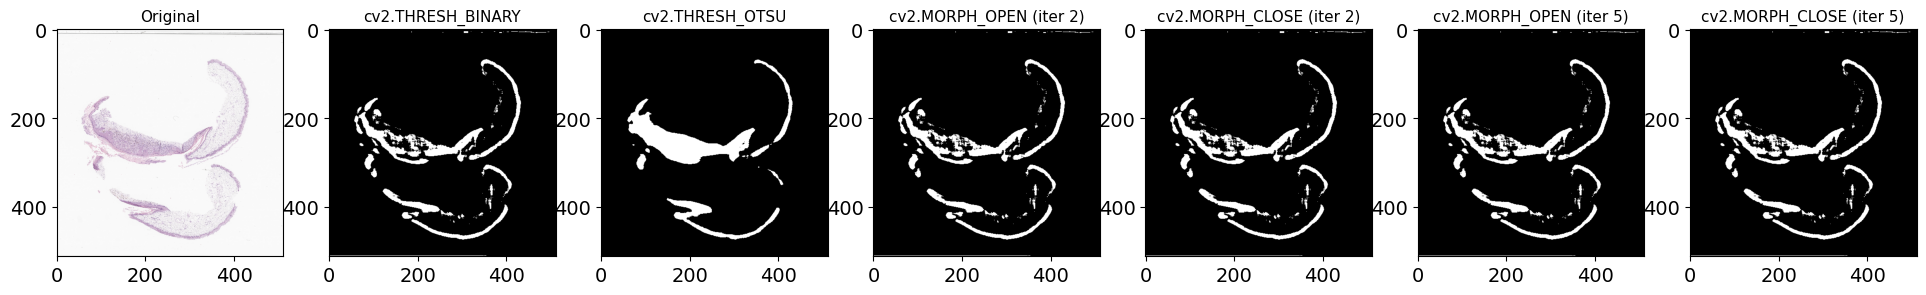

In [18]:
def get_otsu_mask_2(_img, thresh=-1):
    v = cv2.cvtColor(_img, cv2.COLOR_RGB2GRAY)
    v = cv2.medianBlur(v, 15)
    _, timg_th = cv2.threshold(v, thresh, 255, cv2.THRESH_OTSU)
    print(thresh)
    print(_, type(timg_th)) # print(_, timg_th)
    timg_th = cv2.morphologyEx(timg_th, cv2.MORPH_OPEN, tissue_kernel, iterations=2)
    timg_th = cv2.morphologyEx(timg_th, cv2.MORPH_CLOSE, tissue_kernel, iterations=2)
    timg_th = cv2.morphologyEx(timg_th, cv2.MORPH_OPEN, tissue_kernel, iterations=5)
    timg_th = cv2.morphologyEx(timg_th, cv2.MORPH_CLOSE, tissue_kernel, iterations=5)
    return ~timg_th

def plt_get_otsu_mask_2(_img, thresh=230):
    
    plt.figure(figsize=(24, 3)) # (12, 8)
    
    plt.subplot(1, 7, 1)
    plt.imshow(img)
    plt.title('Original', fontsize=11)
    
    v = cv2.cvtColor(_img, cv2.COLOR_RGB2GRAY)
    v = cv2.medianBlur(v, 15)
    
    block_size = 33 # thresholding을 적용할 영역 사이즈 (3 이상의 홀수)
    C = 2 # 계산된 경계 값(평균이나 가중평균)에서 차감할 값 (양수이면 계산된 adaptive 문턱값에서 빼고 음수이면 더해줍니다.
    # 9, 5 / 51, 0 / 11, 2 / 15, 2
    # _, timg_th_temp = cv2.threshold(v, thresh, 255,  cv2.THRESH_BINARY)
    # timg_th_temp = cv2.adaptiveThreshold(v, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, block_size, C) # mean
    timg_th_temp = cv2.adaptiveThreshold(v, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, block_size, C) # gaussian

    # print(thresh)
    # print(_, type(timg_th_temp)) # print(_, timg_th)
    plt.subplot(1, 7, 2)
    plt.imshow(~timg_th_temp, cmap='gray')
    plt.title('cv2.THRESH_BINARY', fontsize=11)
    
    _, timg_th = cv2.threshold(v, thresh, 255, cv2.THRESH_OTSU)
    # print(thresh)
    print('(cv2.THRESH_OTSU) thresh : ', _, type(timg_th)) # print(_, timg_th)
    plt.subplot(1, 7, 3)
    plt.imshow(~timg_th, cmap='gray')
    plt.title('cv2.THRESH_OTSU', fontsize=11)
    
    timg_th = cv2.morphologyEx(timg_th, cv2.MORPH_OPEN, tissue_kernel, iterations=2)
    plt.subplot(1, 7, 4)
    plt.imshow(~timg_th_temp, cmap='gray')
    plt.title('cv2.MORPH_OPEN (iter 2)', fontsize=11)
    
    timg_th = cv2.morphologyEx(timg_th, cv2.MORPH_CLOSE, tissue_kernel, iterations=2)
    plt.subplot(1, 7, 5)
    plt.imshow(~timg_th_temp, cmap='gray')
    plt.title('cv2.MORPH_CLOSE (iter 2)', fontsize=11)
    
    timg_th = cv2.morphologyEx(timg_th, cv2.MORPH_OPEN, tissue_kernel, iterations=5)
    plt.subplot(1, 7, 6)
    plt.imshow(~timg_th_temp, cmap='gray')
    plt.title('cv2.MORPH_OPEN (iter 5)', fontsize=11)
    
    timg_th = cv2.morphologyEx(timg_th, cv2.MORPH_CLOSE, tissue_kernel, iterations=5)
    plt.subplot(1, 7, 7)
    plt.imshow(~timg_th_temp, cmap='gray')
    plt.title('cv2.MORPH_CLOSE (iter 5)', fontsize=11) 
    
    plt.show()
    
    return ~timg_th



grouped_by_patient = df.groupby('Patient_ID')

start_index = 186 # 186 # 37 39 40 46 85_end
for index, (name, group) in enumerate(grouped_by_patient):
    # print(index, name, len(group))
    # print(group['Slide_name'])
    # print(group)
    
    if index < start_index:
        continue
    print('# patient ID : %s | slide counts : %s | group index : %s' %(name, len(group), index))
    
    # for i in range(len(group)):
    # for slide in group:
    for index, row in group.iterrows():
        # print('####', row)
        # print(row['Location'], row['Growth phase'], row['Histologic subtype'], row['Tumor cell type'], row['Precursor lesion'])
        try:
            sample_path = '../dataset/train/%s.png' %row['Slide_name']
            # print(sample_path)
            print(sample_path, " | Location : %s | Growth phase : %s | Histologic subtype : %s | tumor cell type : %s | Precursor lesion : %s" %(row['Location'], row['Growth phase'], row['Histologic subtype'], row['Tumor cell type'], row['Precursor lesion']))
        except:
            break
            
        img = cv2.imread(sample_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # (OpenCV) BGR -> (matplotlib) RGB
        img = cv2.resize(img, (512, 512))
        # print(img.shape)

        # org_img = img/255
        # # print(org_img.shape)
        
        # get_otsu_mask
        otsu_mask_img = plt_get_otsu_mask_2(img) # -1
        # print(otsu_mask_img.shape)
        
        '''
        # check result by thresh
        
        # get_otsu_mask
        otsu_mask_img_0 = get_otsu_mask_2(img, -10) # -1
        # print(otsu_mask_img.shape)

        # get_otsu_mask
        otsu_mask_img_1 = get_otsu_mask_2(img, -2)
        # print(otsu_mask_img.shape)
        
        # get_otsu_mask
        otsu_mask_img_2 = get_otsu_mask_2(img)
        # print(otsu_mask_img.shape)
        
        # get_otsu_mask
        otsu_mask_img_3 = get_otsu_mask_2(img, 0)
        # print(otsu_mask_img.shape)
        
        # get_otsu_mask
        otsu_mask_img_4 = get_otsu_mask_2(img, 1)
        # print(otsu_mask_img.shape)
        
        # get_otsu_mask
        otsu_mask_img_5 = get_otsu_mask_2(img, 2)
        # print(otsu_mask_img.shape)
        
        # get_otsu_mask
        otsu_mask_img_6 = get_otsu_mask_2(img, 250)
        # print(otsu_mask_img.shape)


        plt.figure(figsize=(27, 3)) # (12, 8)

        plt.subplot(1, 8, 1)
        plt.imshow(img)
        plt.title('Original', fontsize=11)
        
        plt.subplot(1, 8, 2)
        plt.imshow(otsu_mask_img_0, cmap='gray') # 512,512
        plt.title('Otsu Mask (thresh -3)', fontsize=11)
        
        plt.subplot(1, 8, 3)
        plt.imshow(otsu_mask_img_1, cmap='gray') # 512,512
        plt.title('Otsu Mask (thresh -2)', fontsize=11)

        plt.subplot(1, 8, 4)
        plt.imshow(otsu_mask_img_2, cmap='gray') # 512,512
        plt.title('Otsu Mask (org)', fontsize=11)
        
        plt.subplot(1, 8, 5)
        plt.imshow(otsu_mask_img_3, cmap='gray') # 512,512
        plt.title('Otsu Mask (thresh 0)', fontsize=11)
        
        plt.subplot(1, 8, 6)
        plt.imshow(otsu_mask_img_4, cmap='gray') # 512,512
        plt.title('Otsu Mask (thresh 1)', fontsize=11)
        
        plt.subplot(1, 8, 7)
        plt.imshow(otsu_mask_img_5, cmap='gray') # 512,512
        plt.title('augmented_10 (thresh 2)', fontsize=11)
        
        plt.subplot(1, 8, 7)
        plt.imshow(otsu_mask_img_6, cmap='gray') # 512,512
        plt.title('augmented_10 (thresh 3)', fontsize=11)
        
        plt.show()
        '''
        
    break

### # Test cv2.threshold (cv2.adaptiveThreshold/cv2.THRESH_OTSU on original/augmented image)

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import albumentations as A
from albumentations.pytorch import ToTensorV2

def get_augmentation_2(cliplimit=None):
    _transform = [
        # A.Rotate(),
        # A.HorizontalFlip(),
        # A.VerticalFlip(),
        # A.ColorJitter(p=1), # A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2, p=1),
        A.CLAHE(clip_limit=cliplimit, p=1) # A.CLAHE(p=1)
    ]
    return A.Compose(_transform)

def get_otsu_mask_2(_img, thresh=-1):
    v = cv2.cvtColor(_img, cv2.COLOR_RGB2GRAY)
    v = cv2.medianBlur(v, 15)
    _, timg_th = cv2.threshold(v, thresh, 255, cv2.THRESH_OTSU)
    print(thresh)
    print(_, type(timg_th)) # print(_, timg_th)
    timg_th = cv2.morphologyEx(timg_th, cv2.MORPH_OPEN, tissue_kernel, iterations=2)
    timg_th = cv2.morphologyEx(timg_th, cv2.MORPH_CLOSE, tissue_kernel, iterations=2)
    timg_th = cv2.morphologyEx(timg_th, cv2.MORPH_OPEN, tissue_kernel, iterations=5)
    timg_th = cv2.morphologyEx(timg_th, cv2.MORPH_CLOSE, tissue_kernel, iterations=5)
    return ~timg_th

def plt_get_otsu_mask_2(_img, thresh=230, name=None):
    
    plt.figure(figsize=(18, 3)) # (12, 8)
    
    plt.subplot(1, 5, 1)
    plt.imshow(img)
    plt.title(name, fontsize=11)
    
    v = cv2.cvtColor(_img, cv2.COLOR_RGB2GRAY)
    v = cv2.medianBlur(v, 15)
    
    block_size = 33 # thresholding을 적용할 영역 사이즈 (3 이상의 홀수)
    C = 2 # 계산된 경계 값(평균이나 가중평균)에서 차감할 값 (양수이면 계산된 adaptive 문턱값에서 빼고 음수이면 더해줍니다.
    # 9, 5 / 51, 0 / 11, 2 / 15, 2
    
    # _, timg_th_temp = cv2.threshold(v, thresh, 255,  cv2.THRESH_BINARY)
    timg_th_temp = cv2.adaptiveThreshold(v, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, block_size, C) # mean
    # timg_th_temp = cv2.adaptiveThreshold(v, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, block_size, C) # gaussian
    # print(thresh)
    # print(_, type(timg_th_temp)) # print(_, timg_th)
    plt.subplot(1, 5, 2)
    plt.imshow(~timg_th_temp, cmap='gray')
    plt.title('cv2.adaptiveThreshold_gaussian', fontsize=11)
    
    _, timg_th = cv2.threshold(v, thresh, 255, cv2.THRESH_OTSU)
    # print(thresh)
    print('(cv2.THRESH_OTSU) thresh : ', _, type(timg_th)) # print(_, timg_th)
    plt.subplot(1, 5, 3)
    plt.imshow(~timg_th, cmap='gray')
    plt.title('cv2.THRESH_OTSU', fontsize=11)
    
    timg_th_temp = cv2.morphologyEx(timg_th_temp, cv2.MORPH_OPEN, tissue_kernel, iterations=2)
    timg_th_temp = cv2.morphologyEx(timg_th_temp, cv2.MORPH_CLOSE, tissue_kernel, iterations=2)
    timg_th_temp = cv2.morphologyEx(timg_th_temp, cv2.MORPH_OPEN, tissue_kernel, iterations=5)
    timg_th_temp = cv2.morphologyEx(timg_th_temp, cv2.MORPH_CLOSE, tissue_kernel, iterations=5)
    plt.subplot(1, 5, 4)
    plt.imshow(~timg_th_temp, cmap='gray')
    plt.title('cv2.adaptiveThreshold_gaussian (final)', fontsize=11)
    
    timg_th = cv2.morphologyEx(timg_th, cv2.MORPH_OPEN, tissue_kernel, iterations=2)
    timg_th = cv2.morphologyEx(timg_th, cv2.MORPH_CLOSE, tissue_kernel, iterations=2)
    timg_th = cv2.morphologyEx(timg_th, cv2.MORPH_OPEN, tissue_kernel, iterations=5)
    timg_th = cv2.morphologyEx(timg_th, cv2.MORPH_CLOSE, tissue_kernel, iterations=5)
    plt.subplot(1, 5, 5)
    plt.imshow(~timg_th, cmap='gray')
    plt.title('cv2.THRESH_OTSU (final)', fontsize=11)
    
    plt.show()
    
    return ~timg_th



grouped_by_patient = df.groupby('Patient_ID')

start_index = 186 # 186 # 37 39 40 46 85_end
for index, (name, group) in enumerate(grouped_by_patient):
    # print(index, name, len(group))
    # print(group['Slide_name'])
    # print(group)
    
    if index < start_index:
        continue
    print('# patient ID : %s | slide counts : %s | group index : %s' %(name, len(group), index))
    
    # for i in range(len(group)):
    # for slide in group:
    for index, row in group.iterrows():
        # print('####', row)
        # print(row['Location'], row['Growth phase'], row['Histologic subtype'], row['Tumor cell type'], row['Precursor lesion'])
        try:
            sample_path = '../dataset/train/%s.png' %row['Slide_name']
            # print(sample_path)
            print(sample_path, " | Location : %s | Growth phase : %s | Histologic subtype : %s | tumor cell type : %s | Precursor lesion : %s" %(row['Location'], row['Growth phase'], row['Histologic subtype'], row['Tumor cell type'], row['Precursor lesion']))
        except:
            break
            
        img = cv2.imread(sample_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # (OpenCV) BGR -> (matplotlib) RGB
        img = cv2.resize(img, (512, 512))
        # print(img.shape)
        # org_img = img/255
        # # print(org_img.shape)
        
        # get_otsu_mask
        otsu_mask_img = plt_get_otsu_mask_2(img, thresh=230, name='Original') # -1
        # print(otsu_mask_img.shape)
        
        # get_augmentation
        augmented_img = get_augmentation_2([10.0, 10.0])(image=img)['image'] # get_augmentation()(image=img)['image']
        # get_otsu_mask
        otsu_mask_img_with_aug = plt_get_otsu_mask_2(augmented_img, thresh=230, name='Augmented')
    
    break

In [20]:
# !pip uninstall opencv-python-headless
# !pip uninstall opencv-python
# !pip install opencv-python

In [21]:
# src = cv2.imread('../dataset/train/train_769.png', cv2.IMREAD_GRAYSCALE)

# if src is None:
#     print('Image load failed!')
#     sys.exit

# # 트랙바 함수 정의
# def on_threshold(pos):
#     _, dst = cv2.threshold(src, pos, 255, cv2.THRESH_BINARY)
#     cv2.imshow('dst', dst)
    
# cv2.imshow('src', src)
# cv2.namedWindow('dst')
# cv2.createTrackbar('Threshold', 'dst', 0, 255, on_threshold) # 임계값 범위 0~255
# cv2.setTrackbarpos('Threshold', 'dst', 128) # 임계값 초기값 128

# cv2.waitKey()
# cv2.destroyAllWindows()

### # Test augmentation for masking (ColorJitter/CLAHE, CLAHE clip_limit)

# patient ID : train_pid_187 | slide counts : 1 | group index : 186
../dataset/train/train_769.png  | Location : finger | Growth phase : nan | Histologic subtype : nan | tumor cell type : nan | Precursor lesion : nan


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


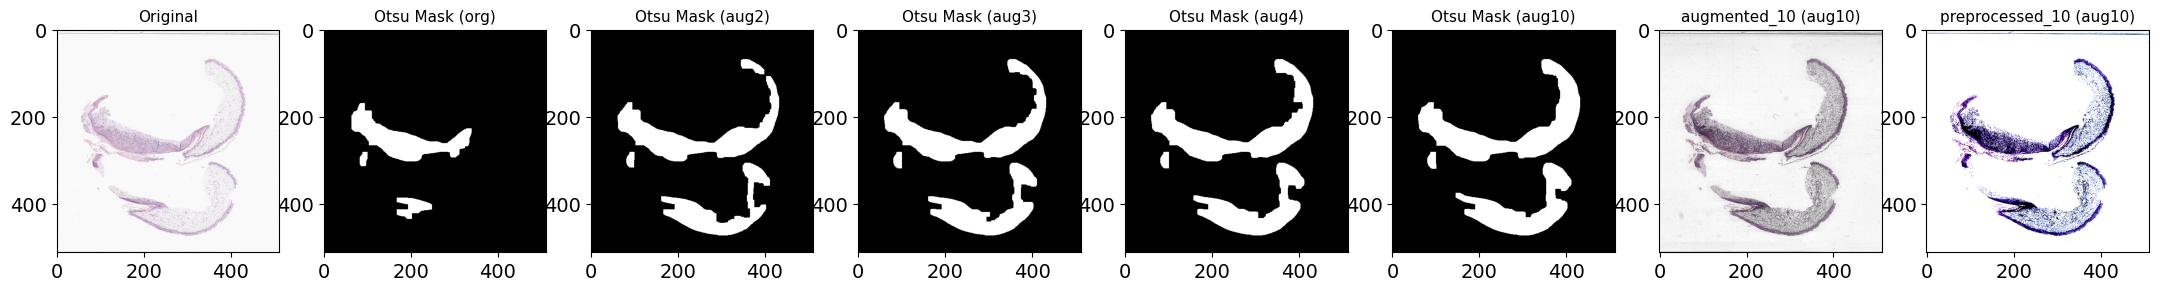

In [25]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import albumentations as A
from albumentations.pytorch import ToTensorV2

def get_augmentation_2(cliplimit=None):
    _transform = [
        # A.Rotate(),
        # A.HorizontalFlip(),
        # A.VerticalFlip(),
        # A.ColorJitter(p=1), # A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2, p=1),
        A.CLAHE(clip_limit=cliplimit, p=1) # A.CLAHE(p=1)
    ]
    return A.Compose(_transform)

grouped_by_patient = df.groupby('Patient_ID')

start_index = 186 # 37 39 40 46 85_end 186 177? 198?
for index, (name, group) in enumerate(grouped_by_patient):
    # print(index, name, len(group))
    # print(group['Slide_name'])
    # print(group)
    
    if index < start_index:
        continue
    print('# patient ID : %s | slide counts : %s | group index : %s' %(name, len(group), index))
    
    # for i in range(len(group)):
    # for slide in group:
    for index, row in group.iterrows():
        # print('####', row)
        # print(row['Location'], row['Growth phase'], row['Histologic subtype'], row['Tumor cell type'], row['Precursor lesion'])
        try:
            sample_path = '../dataset/train/%s.png' %row['Slide_name']
            # print(sample_path)
            print(sample_path, " | Location : %s | Growth phase : %s | Histologic subtype : %s | tumor cell type : %s | Precursor lesion : %s" %(row['Location'], row['Growth phase'], row['Histologic subtype'], row['Tumor cell type'], row['Precursor lesion']))
        except:
            break
            
        img = cv2.imread(sample_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # (OpenCV) BGR -> (matplotlib) RGB
        img = cv2.resize(img, (512, 512))
        # print(img.shape)

        # org_img = img/255
        # # print(org_img.shape)

        # get_otsu_mask
        otsu_mask_img = get_otsu_mask(img)
        # print(otsu_mask_img.shape)

        # # get_augmentation
        # augmented_img_1 = get_augmentation_2([1.0, 1.0])(image=img)['image'] # get_augmentation()(image=img)['image']
        # # get_otsu_mask
        # otsu_mask_img_with_aug_1 = get_otsu_mask(augmented_img_1)
        
        # get_augmentation
        augmented_img_2 = get_augmentation_2([4.0, 4.0])(image=img)['image'] # get_augmentation()(image=img)['image']
        # get_otsu_mask
        otsu_mask_img_with_aug_2 = get_otsu_mask(augmented_img_2)
        
        # get_augmentation
        augmented_img_3 = get_augmentation_2([5.0, 5.0])(image=img)['image'] # get_augmentation()(image=img)['image']
        # get_otsu_mask
        otsu_mask_img_with_aug_3 = get_otsu_mask(augmented_img_3)
        
        # get_augmentation
        augmented_img_4 = get_augmentation_2([6.0, 6.0])(image=img)['image'] # get_augmentation()(image=img)['image']
        # get_otsu_mask
        otsu_mask_img_with_aug_4 = get_otsu_mask(augmented_img_4)
        
        # get_augmentation
        augmented_img_10 = get_augmentation_2([7.0, 7.0])(image=img)['image'] # get_augmentation()(image=img)['image']
        # get_otsu_mask
        otsu_mask_img_with_aug_10 = get_otsu_mask(augmented_img_10)
        
        # get_preprocessing
        preprocessed_img_10 = get_preprocessing()(image=augmented_img_10)['image']

        
        plt.figure(figsize=(27, 3)) # (12, 8)

        plt.subplot(1, 8, 1)
        plt.imshow(img)
        plt.title('Original', fontsize=11)
        
        plt.subplot(1, 8, 2)
        plt.imshow(otsu_mask_img, cmap='gray') # 512,512
        plt.title('Otsu Mask (org)', fontsize=11)
        
        plt.subplot(1, 8, 3)
        plt.imshow(otsu_mask_img_with_aug_2, cmap='gray') # 512,512
        plt.title('Otsu Mask (aug2)', fontsize=11)

        plt.subplot(1, 8, 4)
        plt.imshow(otsu_mask_img_with_aug_3, cmap='gray') # 512,512
        plt.title('Otsu Mask (aug3)', fontsize=11)
        
        plt.subplot(1, 8, 5)
        plt.imshow(otsu_mask_img_with_aug_4, cmap='gray') # 512,512
        plt.title('Otsu Mask (aug4)', fontsize=11)
        
        plt.subplot(1, 8, 6)
        plt.imshow(otsu_mask_img_with_aug_10, cmap='gray') # 512,512
        plt.title('Otsu Mask (aug10)', fontsize=11)
        
        plt.subplot(1, 8, 7)
        plt.imshow(augmented_img_10, cmap='gray') # 512,512
        plt.title('augmented_10 (aug10)', fontsize=11)
        
        plt.subplot(1, 8, 8)
        plt.imshow(np.transpose(preprocessed_img_10.numpy(), (1, 2, 0))) # 512,512
        plt.title('preprocessed_10 (aug10)', fontsize=11)
        
        plt.show()
        
    break

### # Check original -> preprocess journal

# patient ID : train_pid_071 | slide counts : 1 | group index : 70
../dataset/train/train_314.png  | Location : foot | Growth phase : nan | Histologic subtype : nan | tumor cell type : nan | Precursor lesion : nan
###  35222 17143


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


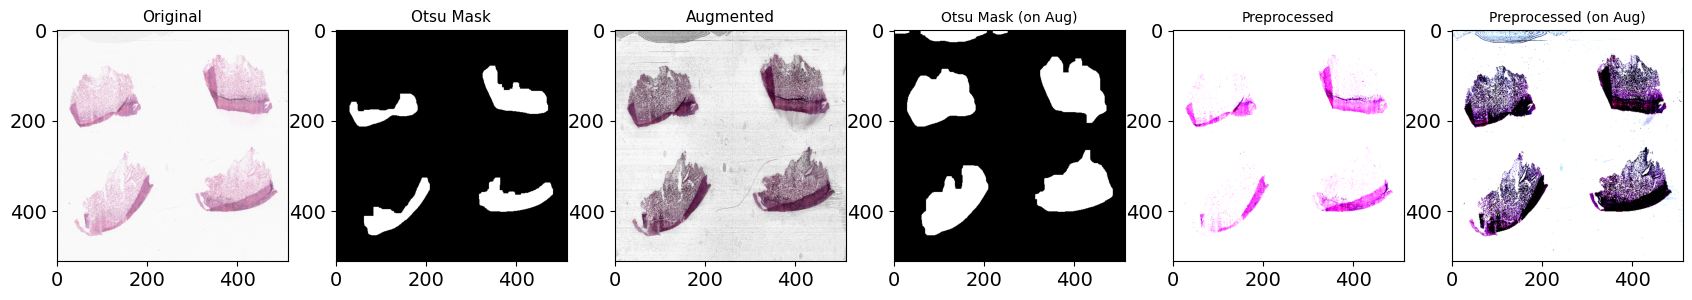

In [260]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import albumentations as A
from albumentations.pytorch import ToTensorV2

from PIL import Image

Image.MAX_IMAGE_PIXELS = None

def get_augmentation_2():
    _transform = [
        # A.Rotate(),
        # A.HorizontalFlip(),
        # A.VerticalFlip(),
        # A.ColorJitter(p=1),
        A.CLAHE(clip_limit=[15.0, 15.0], p=1)
    ]
    return A.Compose(_transform)


grouped_by_patient = df.groupby('Patient_ID')

# for name, group in grouped_by_patient:
#     # print(name, len(group))
#     # print(group['Slide_name'])
    
#     # for i in range(len(group)):
#     for slide in group['Slide_name']:
#         try:
#             sample_path = '../dataset/train/{%s}.png' %slide
#             print(sample_path)
#         except:
#             break

start_index = 70 # 37 39 40 46
for index, (name, group) in enumerate(grouped_by_patient):
    # print(index, name, len(group))
    # print(group['Slide_name'])
    # print(group)
    
    if index < start_index:
        continue
    print('# patient ID : %s | slide counts : %s | group index : %s' %(name, len(group), index))
    
    # for i in range(len(group)):
    # for slide in group:
    for index, row in group.iterrows():
        # print('####', row)
        # print(row['Location'], row['Growth phase'], row['Histologic subtype'], row['Tumor cell type'], row['Precursor lesion'])
        try:
            sample_path = '../dataset/train/%s.png' %row['Slide_name']
            # print(sample_path)
            print(sample_path, " | Location : %s | Growth phase : %s | Histologic subtype : %s | tumor cell type : %s | Precursor lesion : %s" %(row['Location'], row['Growth phase'], row['Histologic subtype'], row['Tumor cell type'], row['Precursor lesion']))
        except:
            break
            
        image = Image.open(sample_path)
        width, height = image.size
        print('### ', width, height)
        
        img = cv2.imread(sample_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # (OpenCV) BGR -> (matplotlib) RGB
        img = cv2.resize(img, (512, 512))
        # print(img.shape)

        # org_img = img/255
        # # print(org_img.shape)

        # get_otsu_mask
        otsu_mask_img = get_otsu_mask(img)
        # print(otsu_mask_img.shape)

        # get_augmentation
        augmented_img = get_augmentation_2()(image=img)['image'] # get_augmentation()(image=img)['image']
        # print(augmented_img.shape)
        
        # get_otsu_mask
        otsu_mask_img_with_aug = get_otsu_mask(augmented_img)
        # print(otsu_mask_img.shape)

        # get_preprocessing
        preprocessed_img = get_preprocessing()(image=img)['image']
        # print(preprocessed_img.shape)
        
        preprocessed_img_with_aug = get_preprocessing()(image=augmented_img)['image']

        plt.figure(figsize=(21, 3)) # (12, 8)

        plt.subplot(1, 6, 1)
        plt.imshow(img)
        plt.title('Original', fontsize=11)

        plt.subplot(1, 6, 2)
        plt.imshow(otsu_mask_img, cmap='gray') # 512,512
        plt.title('Otsu Mask', fontsize=11)

        plt.subplot(1, 6, 3)
        plt.imshow(augmented_img) # 512,512,3
        plt.title('Augmented', fontsize=11)
        
        plt.subplot(1, 6, 4)
        plt.imshow(otsu_mask_img_with_aug, cmap='gray') # 512,512,3
        plt.title('Otsu Mask (on Aug)', fontsize=10)

        plt.subplot(1, 6, 5)
        plt.imshow(np.transpose(preprocessed_img.numpy(), (1, 2, 0))) #torch.Size([3, 512, 512]) totensor때문.
        plt.title('Preprocessed', fontsize=10)
        
        plt.subplot(1, 6, 6)
        plt.imshow(np.transpose(preprocessed_img_with_aug.numpy(), (1, 2, 0))) #torch.Size([3, 512, 512]) totensor때문.
        plt.title('Preprocessed (on Aug)', fontsize=10)

        plt.show()
        
    break

In [ ]:
# import cv2
# import numpy as np
# import matplotlib.pyplot as plt
# import albumentations as A
# from albumentations.pytorch import ToTensorV2

# # interval = 15
# # for i in range(1,df.shape[0],15):
# #     for j in range(15):
# #         try:
# #         sample_path = '../dataset/train/train_{0:03d}.png'.format(i+j)
# #         print(sample_path)
# #     except:
# #         break


# start_index = 16
# for i in range(3):
#     try:
#         sample_path = '../dataset/train/train_{0:03d}.png'.format(start_index+i)
#         print(sample_path)
#     except:
#         break

#     img = cv2.imread(sample_path)
#     img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # (OpenCV) BGR -> (matplotlib) RGB
#     img = cv2.resize(img, (512, 512))
#     # print(img.shape)
    
#     # org_img = img/255
#     # # print(org_img.shape)

#     # get_otsu_mask
#     otsu_mask_img = get_otsu_mask(img)
#     # print(otsu_mask_img.shape)

#     # get_augmentation
#     augmented_img = get_augmentation()(image=img)['image']
#     # print(augmented_img.shape)

#     # get_preprocessing
#     preprocessed_img = get_preprocessing()(image=img)['image']
#     # print(preprocessed_img.shape)

#     plt.figure(figsize=(20, 4)) # (12, 8)

#     plt.subplot(1, 4, 1)
#     plt.imshow(img)
#     plt.title('Original Image', fontsize=12)

#     plt.subplot(1, 4, 2)
#     plt.imshow(otsu_mask_img, cmap='gray') # 512,512
#     plt.title('Otsu Mask', fontsize=12)

#     plt.subplot(1, 4, 3)
#     plt.imshow(augmented_img) # 512,512,3
#     plt.title('Augmented Image', fontsize=12)

#     plt.subplot(1, 4, 4)
#     plt.imshow(np.transpose(preprocessed_img.numpy(), (1, 2, 0))) #torch.Size([3, 512, 512]) totensor때문.
#     plt.title('Preprocessed Image', fontsize=12)

#     plt.show()